<a href="https://colab.research.google.com/github/DmitryKutsev/DeepHW/blob/master/my_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-10-15 15:19:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  11.4MB/s    in 59s     

2020-10-15 15:20:29 (11.1 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [1]:
!wget https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py

--2020-10-15 15:19:28--  https://raw.githubusercontent.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/master/Week%203/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10563 (10K) [text/plain]
Saving to: ‘data.py’

data.py             100%[===================>]  10.32K  --.-KB/s    in 0s      

2020-10-15 15:19:28 (92.4 MB/s) - ‘data.py’ saved [10563/10563]



In [2]:
!mv data.py mydata.py

In [4]:
import math
import numpy as np
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import zipfile
from torch import nn
import seaborn as sns
from mydata import Downloader, Parser
import matplotlib.pyplot as plt

In [5]:
torch.__version__

'1.6.0+cu101'

### **DATA**


In [5]:
data_path = './my_data/'

In [6]:
downloader = Downloader(data_path=data_path)

In [7]:
downloader.run()

multiple: 100%|██████████| 17/17 [00:00<00:00, 19.67it/s]


In [8]:
parser = Parser(data_path=data_path)

In [9]:

unlabeled, train, valid = parser.run()

Reading: 100%|██████████| 38/38 [02:38<00:00,  4.16s/it]


In [10]:
s = 'ривет привет как дела? ха, дерьмо.'
wordpunct_tokenize(s)

['ривет', 'привет', 'как', 'дела', '?', 'ха', ',', 'дерьмо', '.']

In [11]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())

category2index = {category: index for index, category in enumerate(unique_categories)}

In [12]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [13]:
valid['target'][:3]

0    3
1    6
2    2
Name: target, dtype: int64

In [39]:
class TextClassificationDataset(Dataset):
    
    def __init__(self, texts, targets, vocab, pad_index=0, max_length=32):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = vocab
        
        self.pad_index = pad_index
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def tokenization(self, text):
        
        tokens = wordpunct_tokenize(text)
        
        token_indices = [self.vocab[tok] for tok in tokens if tok in self.vocab]
        
        return token_indices
    
    def padding(self, tokenized_text):
        
        tokenized_text = tokenized_text[:self.max_length]
        
        tokenized_text += [self.pad_index] * (self.max_length - len(tokenized_text))
        
        return tokenized_text
    
    def __getitem__(self, index):
        
        text = self.texts[index]        
        target = self.targets[index]
        
        tokenized_text = self.tokenization(text)
        tokenized_text = self.padding(tokenized_text)
        
        tokenized_text = torch.tensor(tokenized_text)
        
        return tokenized_text, target

In [40]:
train_x = list(train.question)
train_y = list(train.target)

valid_x = list(valid.question)
valid_y = list(valid.target)

### **Embeddings**

In [41]:
def load_embeddings(zip_path, filename, pad_token='PAD', max_words=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
            max_words = vocab_size if max_words <= 0 else max_words
            
            # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [42]:
vocab, embeddings = load_embeddings('./wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)

100%|█████████▉| 99999/100000 [00:12<00:00, 8251.67it/s]


In [43]:
index2token = {index: token for token, index in vocab.items()}

In [44]:
emb_norms = np.linalg.norm(embeddings, axis=1)

In [45]:
#print(len(train_loader))

In [46]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
x, y = train_dataset[0]

In [47]:
embeddings = torch.tensor(embeddings).float()
embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
x_embed = embedding_layer(x)

In [48]:
train_dataset = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_dataset = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_dataset, batch_size=128)
valid_loader = DataLoader(valid_dataset, batch_size=128)

In [49]:
for x, y in train_loader:
  print(x.size())
  print(y.size())
  break

torch.Size([128, 32])
torch.Size([128])


'is it possible to wear eye protection and these ear muffs at same time? we need something for our son to wear which will not interfere with his safety'

### **AVERAGE MODEL**

In [52]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, embeddings, linear_1_size, linear_2_size, n_classes):
        super().__init__()
        
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)
        
        self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
        
        self.linear_1 = nn.Linear(in_features=embeddings.shape[-1], out_features=linear_1_size)
        self.linear_2 = nn.Linear(in_features=linear_1_size, out_features=linear_2_size)
        self.linear_3 = nn.Linear(in_features=linear_2_size, out_features=n_classes)
        
    def forward(self, x):
        
        # переводим индексы слов в эмбеддинги этих слов
        # (batch_size, sequence_length) -> (batch_size, sequence_length, embedding_dim)
        x = self.embedding_layer(x)
        
        # агрегируем наши эмбеддинги по размерности время
        # (batch_size, sequence_length, embedding_dim) -> (batch_size, embedding_dim)
        x = x.sum(dim=1)
        
        # делаем нормирование
        # (batch_size, embedding_dim) -> (batch_size, embedding_dim)
        x = self.batch_norm(x)
        
        # прогоняем через первый линейный слой
        # (batch_size, embedding_dim) -> (batch_size, linear_1_size)
        x = self.linear_1(x)
        
        # применяем нелинейность
        # (batch_size, linear_1_size) -> (batch_size, linear_1_size)
        x = torch.relu(x)
        
        # прогоняем через второй линейный слой
        # (batch_size, linear_1_size) -> (batch_size, linear_2_size)
        x = self.linear_2(x)
        
        # применяем нелинейность
        # (batch_size, linear_2_size) -> (batch_size, linear_2_size)
        x = torch.relu(x)
        
        # переводим с помощью линейного преобразования в количество классов
        # (batch_size, linear_2_size) -> (batch_size, n_classes)
        x = self.linear_3(x)
        
        ## по идеи здесь должен был быть софтмакс
        ## но мы будем использовать лосс nn.CrossEntropyLoss()
        ## в его документации написано
        ## This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.
        ## это некоторая оптимизация, которая включает в себя сразу и софтмакс и сам negative log likelihood лосс
        ## так как у нас в лоссе есть софтмакс, то мы не будем применять его в сетке
        ## на этапе предсказания (а не обучения) мы будем отдельно делать софтмакс для получения распределения классов
        ## 
        ## (batch_size, n_classes) -> (batch_size, n_classes)
        # x = torch.softmax(x, dim=-1)
        
        return x

In [53]:

model = DeepAverageNetwork(embeddings=embeddings,
                           linear_1_size=256, 
                           linear_2_size=128, 
                           n_classes=len(category2index))

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [55]:

epochs = 3
losses = []
for i in range(epochs):
  for x, y in train_loader:
    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")


epoch 0, loss 0.8249971866607666
epoch 1, loss 0.6914821863174438
epoch 2, loss 0.601625382900238


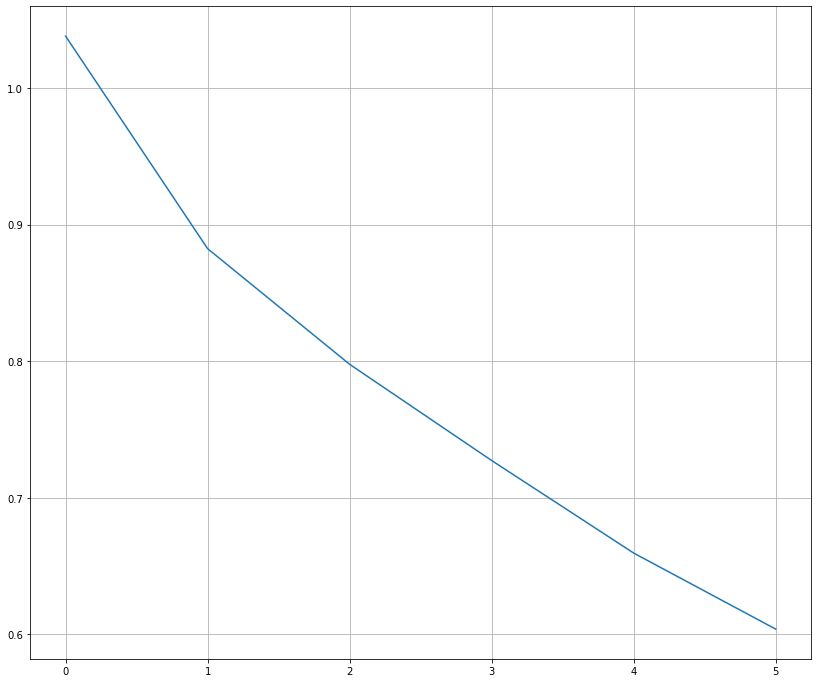

In [29]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [38]:
losses = list()
preds = list()
acc_list = list()
# это переводит модель в режим предсказания
# то есть фиксируются статистики батч норма, дропаут не выкидывает фичи
# model.eval()

# заметьте, что мы поменяли наш лоадер на валидационный
losses = []

for i in range(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          # if count == 3:
          #   print(y_pred.argmax())
          #   print(y)
          # count += 1

          #loss = criterion(y_pred, y)
          ## (batch_size, n_classes) -> (batch_size, n_classes)
          # x = torch.softmax(x, dim=-1)
          

          optimizer.zero_grad()
          # loss.backward()
          optimizer.step()
          losses.append(loss)

          optimizer.zero_grad()
          # loss.backward()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 0.8494126200675964
epoch 1, loss 0.8494126200675964
epoch 2, loss 0.8494126200675964
epoch 3, loss 0.8494126200675964
epoch 4, loss 0.8494126200675964
epoch 5, loss 0.8494126200675964


In [39]:
 preds[:3]

[]

In [40]:
losses = list()

# это переводит модель в режим предсказания
# то есть фиксируются статистики батч норма, дропаут не выкидывает фичи
model.eval()

# заметьте, что мы поменяли наш лоадер на валидационный
for x, y in valid_loader:
    
    with torch.no_grad():
        # получение предсказаний модели
        # расчет лосса
          y_pred = model.forward(x)
          loss = criterion(y_pred, y)
          losses.append(loss)
    

### **CNN**

In [69]:
class MyCNN(nn.Module):
# c1_in=32, c2_in=64, c2_out=101, l1_out=16384, l2_out=64
  def __init__(self, embeddings, c1_in, c2_in, c2_out, l1_out, l2_out, n_classes):

    super().__init__()

    self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.conv1 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, stride=1, padding=1)

    self.batch_norm = nn.BatchNorm1d(num_features=embeddings.shape[-1])
    self.dropout = nn.Dropout(p=0.5)
    
    self.linear_1 = nn.Linear(in_features=101, out_features=32)
    self.linear_2 = nn.Linear(in_features=32, out_features=16)
    self.linear_3 = nn.Linear(in_features=16, out_features=n_classes)


  def forward(self, x):

    x = self.embedding_layer(x)
    x = self.conv1(x)
    # print(x.size())
    x = torch.max_pool1d(x, kernel_size=3)
    # print(x.size())
    x = self.relu(x)
    # print(x.size())
    x = self.conv2(x)
    # print(x.size())
    x = x.sum(dim=1)
    # print(x.size())

    x = self.linear_1(x)
    # print(x.size())


    x = torch.relu(x)
    # print(x.size())


    x = self.linear_2(x)
    # print(x.size())
    x = self.dropout(x)

    x = torch.relu(x)
    # print(x.size())
    # print(y.size())
    # переводим с помощью линейного преобразования в количество классов
    # (batch_size, linear_2_size) -> (batch_size, n_classes)
    x = self.linear_3(x)
 

    return x


In [73]:
model = MyCNN(embeddings=embeddings,
                          c1_in=32, 
                          c2_in=64, 
                          c2_out=101,
                          l1_out=32, 
                          l2_out=16,
                           n_classes=len(category2index))


In [74]:
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.CUDA()

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

epochs = 3
losses = []
for i in range(epochs):
  for x, y in train_loader:
    if CUDA:
      x = x.CUDA()
      y = y.CUDA()

    y_pred = model.forward(x)
    loss = criterion(y_pred, y)
    
     

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 1.8375054597854614
epoch 1, loss 1.494188904762268
epoch 2, loss 1.4907337427139282


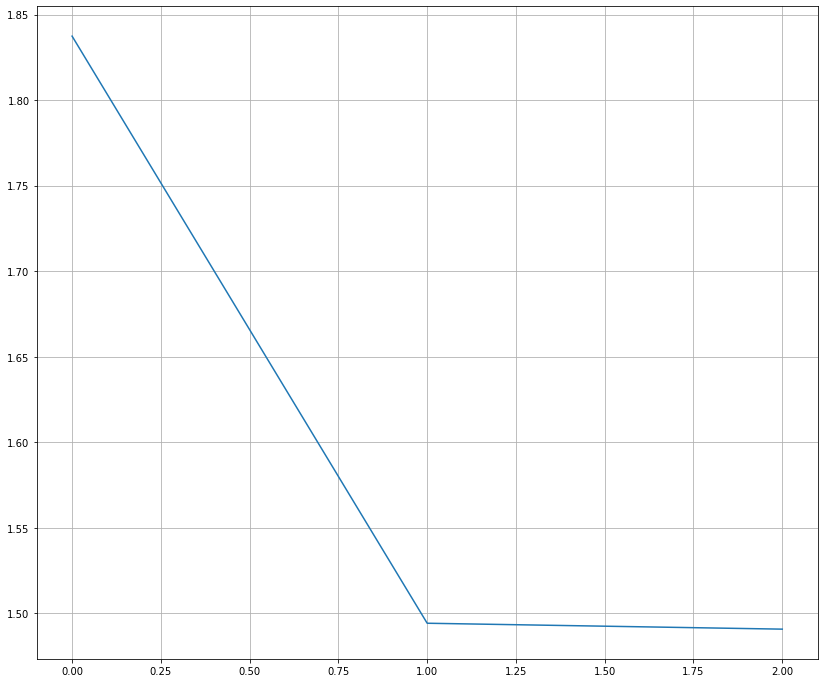

In [76]:
plt.figure(figsize=(14, 12))
plt.plot(range(epochs), losses)
plt.grid()

In [77]:
losses = list()
preds = list()
acc_list = list()

# заметьте, что мы поменяли наш лоадер на валидационный
losses = []

for i in range(epochs):
  count = 0
  for x, y in valid_loader:
      
      with torch.no_grad():
          
          x_forw = model.forward(x)
          y_pred = torch.softmax(x_forw, dim=-1)
          optimizer.zero_grad()

          optimizer.step()
          losses.append(loss)
          optimizer.zero_grad()
          optimizer.step()
          losses.append(loss)
  print(f"epoch {i}, loss {loss}")

epoch 0, loss 1.4907337427139282
epoch 1, loss 1.4907337427139282
epoch 2, loss 1.4907337427139282
